In [1]:
# Set up interactive plotting using matplotlib, and load numpy
# %pylab ipympl
%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Import PODPAC dependencies

In [2]:
from collections import OrderedDict
import podpac
from podpac.datalib import smap

## Provide Earth Data Login Credentials
If you do not have an earth data login, or have not activated OpenDAP access, follow the [instructions here](https://creare-com.github.io/podpac-docs/user/earthdata.html)

In [3]:
import getpass
username = password = None
username = input("Username:");   password = getpass.getpass('Password:')

Username: username
Password: ··················


# Create the PODPAC SMAP Node, selecting the Sentinel product

In [4]:
# Create the SMAP node
product = 'SPL2SMAP_S'   # Level 2 SMAP-Sentinel Data
sm = smap.SMAP(product=product, interpolation='nearest', username=username, password=password)

# Retrieve and plot SMAP data for:
## * A particular date
## * Over lat-lon range with user-specified grid

In [5]:
# !!! This takes quite a while since it retrieves data from a lot of tiles (100's)
# dim = (start, stop, step)
lat =   (   90,  -90,-0.5)
lon =   ( -180,  180, 0.5)
# dim = [value, value, value, ...]
time = ['2018-05-05T12:00:00', '2018-05-06T12:00:00']

c_world = podpac.Coordinates([podpac.crange(*lat),
                              podpac.crange(*lon),
                              time], dims=['lat', 'lon', 'time'])
sm.interpolation = 'nearest_preview'
o = sm.eval(c_world)


(-180.25, 180.25, -90.25, 90.25)

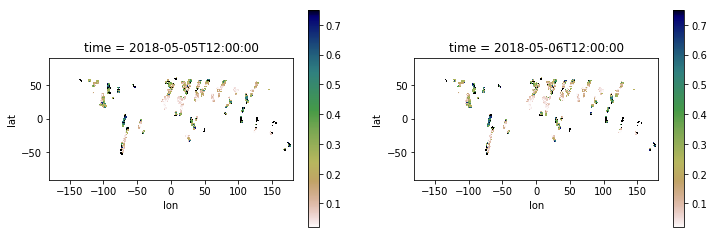

In [6]:
close('all')
figure(figsize=(12, 4))
subplot(121);o[..., 0].plot(cmap='gist_earth_r'); axis('scaled')
subplot(122);o[..., 1].plot(cmap='gist_earth_r'); axis('scaled')

# Figure out how often a tile is available for each 1°x1° square of the earth
# While doing that, also find pairs of tiles that overlap for the same date/time/area

In [7]:
# !!!!! This next line will take a very long while first time it is run
pnc3, srcs3 = sm.get_filename_coordinates_sources()
pnc3

Coordinates
	time_lat_lon[time]: ArrayCoordinates1d(time): Bounds[2016-06-08T03:02:56, 2018-06-03T10:37:52], N[265284], ctype['midpoint']
	time_lat_lon[lat]: ArrayCoordinates1d(lat): Bounds[-55.0, 61.0], N[265284], ctype['midpoint']
	time_lat_lon[lon]: ArrayCoordinates1d(lon): Bounds[-177.0, 177.0], N[265284], ctype['midpoint']

In [8]:
world_hist = np.zeros((180, 360))
time_pair = -np.ones((180, 360), int)
time_pair_delta = np.zeros((180, 360), 'datetime64[h]')
time_pair_inds = OrderedDict()
time_pair_srcs = OrderedDict()

In [9]:
time_pair_delta[:] = pnc3['time'].coords[0]
# Loop through every coordinate (that describes a single data tile)
for k in range(pnc3.shape[0]):
    # Extract the indexes based on the lat-lon coordinates
    lat = int((90 - (pnc3['lat'].coords[k])))
    lon = int((180 + (pnc3['lon'].coords[k])))
    # Count this tile
    world_hist[lat, lon] += 1

    # Record the time for the tile
    time = (pnc3['time'].coords[k])
    # Check if another tile has visited this region
    if time_pair[lat, lon] != -1: 
        # Another tile has visited this region. Was it recent enough to constitute an overlap? 
        if time - time_pair_delta[lat, lon] < np.timedelta64(1, 'D'):
            # Yes, recent enough to constitute and overlap, record this pair
            time_pair_inds[time] = (time_pair[lat, lon], k)
            time_pair_srcs[time] = (srcs3[time_pair[lat, lon]], srcs3[k])
    # record this tile and its visit time
    time_pair[lat, lon] = k
    time_pair_delta[lat, lon] = time

# Set regions with no visits to nan
world_hist[world_hist == 0] = np.nan

(-0.5, 359.5, 179.5, -0.5)

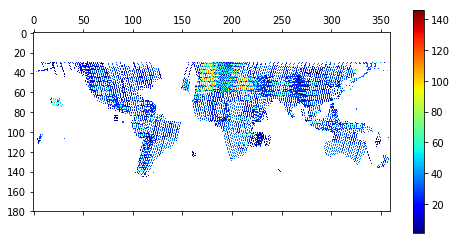

In [10]:
matshow(world_hist, cmap='jet'); colorbar(); axis('scaled')

In [11]:
# Get the last pair of overlapping tiles found and plot the results
srcs = time_pair_srcs[next(reversed(time_pair_srcs))]
srcs

(SMAPSource DataSource
 	source: https://n5eil01u.ecs.nsidc.org/opendap/SMAP/SPL2SMAP_S.001/2018.06.02/SMAP_L2_SM_SP_1AIWDV_20180602T103231_20180602T100208_064W03N_R15182_001.h5
 	interpolation: {'method': 'nearest', 'time_tolerance': numpy.timedelta64(1)},
 SMAPSource DataSource
 	source: https://n5eil01u.ecs.nsidc.org/opendap/SMAP/SPL2SMAP_S.001/2018.06.02/SMAP_L2_SM_SP_1BIWDV_20180602T103231_20180601T223146_064W03N_R15182_001.h5
 	interpolation: {'method': 'nearest', 'time_tolerance': numpy.timedelta64(1)})

In [12]:
srcs[0].native_coordinates

Coordinates
	time: ArrayCoordinates1d(time): Bounds[2018-06-02T10:32:31, 2018-06-02T10:32:31], N[1], ctype['midpoint']
	lat: ArrayCoordinates1d(lat): Bounds[1.910759687423706, 4.2364821434021], N[297], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-65.81441497802734, -63.11719512939453], N[261], ctype['midpoint']

In [13]:
srcs[1].native_coordinates

Coordinates
	time: ArrayCoordinates1d(time): Bounds[2018-06-02T10:32:31, 2018-06-02T10:32:31], N[1], ctype['midpoint']
	lat: ArrayCoordinates1d(lat): Bounds[2.9001717567443848, 4.944807052612305], N[261], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-65.34761047363281, -62.74391174316406], N[252], ctype['midpoint']

In [14]:
coords = srcs[0].native_coordinates.drop('time')
o0 = srcs[0].eval(srcs[0].native_coordinates)
o1 = srcs[1].eval(podpac.core.coordinates.merge_dims([
    srcs[1].native_coordinates.drop(['lat', 'lon']), coords]))

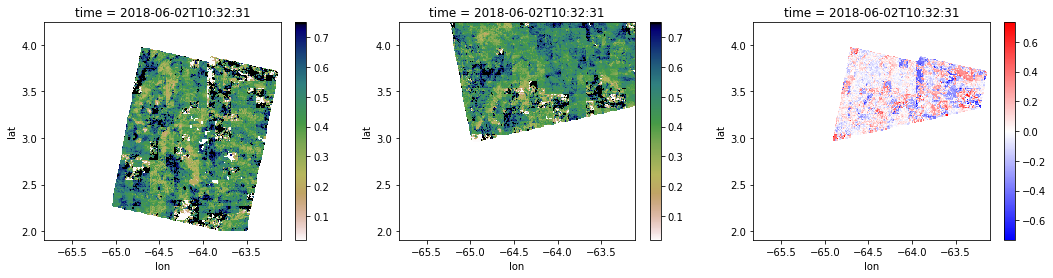

In [15]:
figure(figsize=(18, 4))
ax = subplot(131);                   o0.plot(cmap='gist_earth_r');  
subplot(132, sharex=ax, sharey=ax);  o1.plot(cmap='gist_earth_r');  
subplot(133, sharex=ax, sharey=ax); (o0-o1).plot(cmap='bwr');       